## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:

# Project
Microsoft sees all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but the problem is they don’t know anything about creating movies. They have hired you to help them better understand the movie industry.
Your team is charged with doing data analysis and creating a presentation that explores what type of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.

* Your project contains at least 4 meaningful data visualizations, with corresponding interpretations. All visualizations are well labeled with axes labels, a title, and a legend (when appropriate)  
* You pose at least 3 meaningful questions and answer them through EDA.  These questions should be well labeled and easy to identify inside the notebook.
    * **Level Up**: Each question is clearly answered with a visualization that makes the answer easy to understand.   
* Your notebook should contain 1 - 2 paragraphs briefly explaining your approach to this project.

# Question Ideas
 
* Which movies did best (revenue) based on genre over time? 
* Does having a male or femaled have an effect on ticket sales? 
* Are there differences in preference for certain genres in different countries?

# Primary Questions 
* Which are the most profitable genres of movies to make? 
* Which directors and actors are in the best reviewed movies? Which are the best to recruit? 
* How long should your movie be? (length from imdb + ratings) 
* What is the best time of year to release a movie? 
* How much money needs to be spent to make a successful movie? 
* Is there a difference in profits between releasing a streaming movie vs. in person? 

# Sources: moviefone, imdb, boxofficemojo 

* Notes: use one dataset to answer question and then other datasets to join to supplement it 

# unused data 

In [1]:
#imdb
name_basics = pd.read_csv('zippedData/imdb/name.basics.csv')
title_akas = pd.read_csv('zippedData/imdb/title.akas.csv')
title_basics = pd.read_csv('zippedData/imdb/title.basics.csv')
title_crew = pd.read_csv('zippedData/imdb/title.crew.csv')
title_principals = pd.read_csv('zippedData/imdb/title.principals.csv')
title_ratings = pd.read_csv('zippedData/imdb/title.ratings.csv')

#thenumbers
movie_budgets = pd.read_csv('zippedData/budgets/tn.movie_budgets.csv')
#box office mojo 
movie_revenue = pd.read_csv('zippedData/bom/bom_movie_gross.csv')
#tmdb

#rotten tomatoes 
reviews = pd.read_csv('zippedData/rotten_tomatoes/rt_reviews.tsv', sep='\t', encoding='unicode_escape')
movie_info = pd.read_csv('zippedData/rotten_tomatoes/rt_movie_info.tsv', sep='\t', encoding='unicode_escape')

NameError: name 'pd' is not defined

# Start from Here

In [63]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time
from datetime import datetime

In [64]:

tmdb_movies = pd.read_csv('zippedData/tmdb/tmdb_movies.csv', index_col=0)
tmdb_movies_updated =  pd.read_csv('zippedData/tmdb/tmdb_movies_updated.csv',index_col=0)  #/tmdb_scrape.py
tmdb_genres = pd.read_csv('zippedData/tmdb/tmdb_genres.csv', index_col=0) #TMDB scraping jupyter notebook
print(len(tmdb_movies))# 26517
print(len(tmdb_movies_updated)) #26517

26517
26517


# (1) Which genre should I choose? 
* Which ones gives the most popular, most profitable, and give the most ROI 

Edit the genre column and dates column

In [65]:
# edit the main dataframe tmdb_movies_updated
# convert the genre ids from strings into lists of numbers 
def convert_list(lst):
    try:
        lst1 = lst.strip('][').split(', ')
        return [int(x) for x in lst1]
    except:
        return 0
    
# convert the genre columns to numbers and 
tmdb_movies_updated['genre_ids'] = tmdb_movies_updated.genre_ids.apply(lambda x: convert_list(x))

#convert the release date column to datetime 
tmdb_movies_updated.release_date = tmdb_movies_updated.release_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) 

# drop duplicates 
tmdb_movies_updated = tmdb_movies_updated.drop_duplicates(subset=['id'])
len(tmdb_movies_updated) #25497

25497

# (1a) What genres are the most profitable? 

In [66]:
df = tmdb_movies_updated

# add profits column 
df['profits'] = df['revenue'] - df['budget']

# add roi column 
df['roi'] = df['revenue']/df['budget']
df['roi'] = df['roi'].round(1)

# only consider movies with a budget of 10K or greater 
df = df[df['budget'] > 9999]
df = df.sort_values(by='profits',ascending=False)

# drop columns with no genres listed  
df = df[df['genre_ids'] != 0]

#df['profits_mill'] = df['profits'].apply(lambda x: int(round(x / 1000000, 0)))
recent_movies = df[df.release_date >= datetime(2010,1,1)]

print(len(df)) # 4051 
print(len(recent_movies)) #3956 
print(len(tmdb_movies_updated)) #25497

4051
3956
25497


In [71]:
# group genre by combined profits 

# df[df['genre_ids'].apply(lambda x: 28 in x)]

# calculate profits for all movies in one genre category 
def calculate_profits(df, genre): 
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] # get a dataframe of just that genre 
    profits = sub_df['profits'].sum() # sum the profits 
    return profits

# add a profits total column summing the profits for each genre 
genres_df['profits_total'] = tmdb_genres.id.apply(lambda x: calculate_profits(df, x))
genres_df = genres_df.sort_values(by="profits_total")

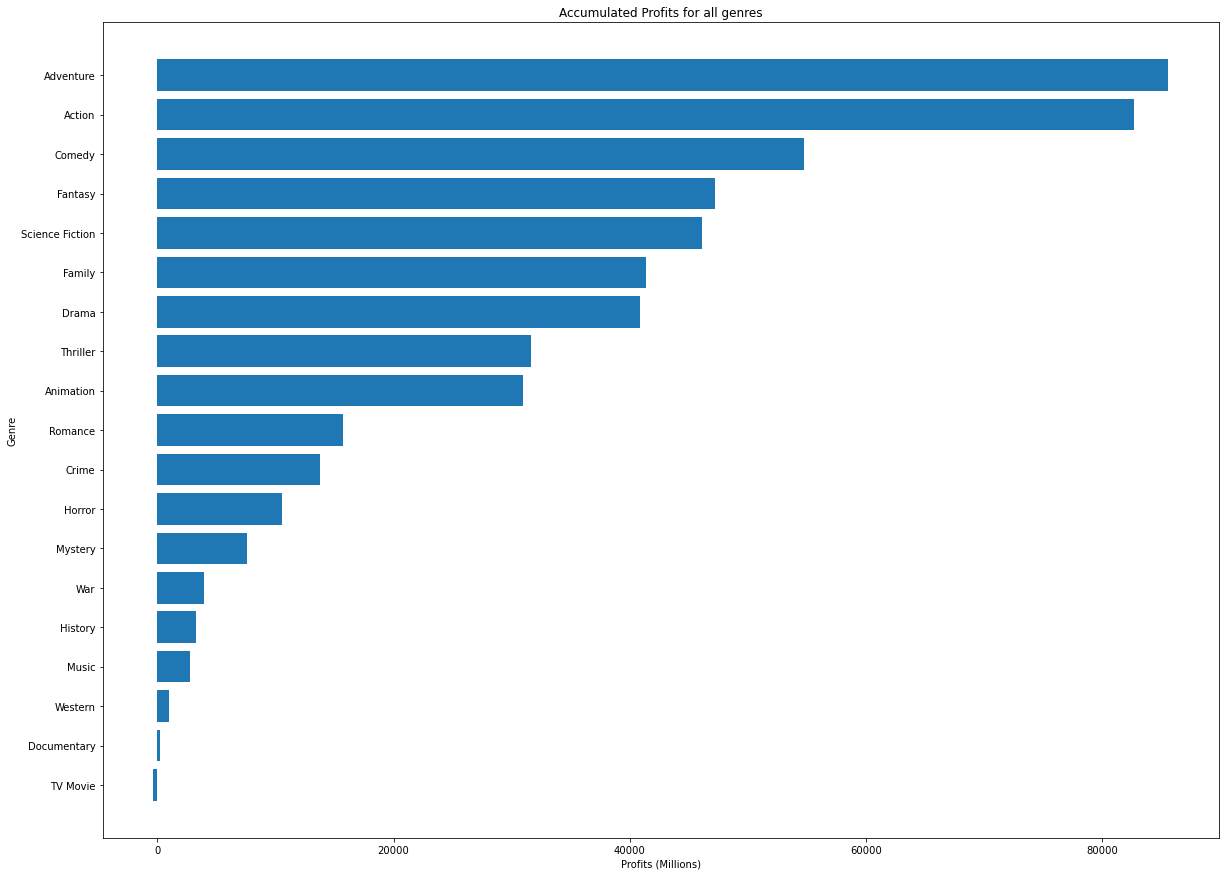

In [72]:
# map the genre names from tmdb_genres to genre_scores_dict number 
# plot to show most profitable genres 
plt.figure(figsize=(20,15))
plt.barh(genres_df['genre'],genres_df['profits_total']/1000000)
plt.xlabel('Profits (Millions)')
plt.ylabel('Genre')
plt.title('Accumulated Profits for all genres')
plt.show()


* So the most profitable genres are: Adventure, Action, Comedy, Fantasy and Sci Fi 

# (1b) What genre combinations are the most profitable? 

In [74]:
# create a list of all the combinations of genres 
genre_list = list(tmdb_genres['id'])
print(genre_list)
print(genre_list[1:]) #[28, 12, 16, 35, 80, 99, 18, 10751, 14, 36, 27, 10402, 9648, 10749, 878, 10770, 53, 10752, 37]
# in reverse 
print(genre_list[1:][::-1]) #[37, 10752, 53, 10770, 878, 10749, 9648, 10402, 27, 36, 14, 10751, 18, 99, 80, 35, 16, 12]

combinations = []
# loop by index  
for i1 in range(len(genre_list)):
    # start from the current index + 1 and go to the end 
     for i2 in range(i1+1,len(genre_list)):
        # add list of outer loop item and all inner loop items 
        combinations.append([genre_list[i1],genre_list[i2]])
len(combinations)  # 171        

[28, 12, 16, 35, 80, 99, 18, 10751, 14, 36, 27, 10402, 9648, 10749, 878, 10770, 53, 10752, 37]
[12, 16, 35, 80, 99, 18, 10751, 14, 36, 27, 10402, 9648, 10749, 878, 10770, 53, 10752, 37]
[37, 10752, 53, 10770, 878, 10749, 9648, 10402, 27, 36, 14, 10751, 18, 99, 80, 35, 16, 12]


171

In [75]:
# sort each combination of genre by profits 
# create a dataframe from the combinations list 
combination_df = pd.DataFrame({0:combinations})
combination_df.columns = ['combinations']
combination_df['profits_total'] = 0

# method to compare one combination of genres to all movies in top 1000 list 
# both elements in each combination have to be in genre_ids column for there to be a match 

#    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combo))]

def add_profits(df, combination):
    total_profits = 0 
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))]
    total_profits = sub_df['profits'].sum()
    return total_profits 

# loop through all combinations using the above method and add as a new column, then sort by total profits 
combination_df['profits_total'] = combination_df.combinations.apply(lambda x: add_profits(df, x))
combination_df = combination_df.sort_values(by=['profits_total'],ascending=False)
combination_df.head()

,combinations,profits_total
0,"[28, 12]",56425324863
13,"[28, 878]",39614597136
24,"[12, 14]",38876832059
30,"[12, 878]",35333277923
39,"[16, 10751]",30018641311


In [78]:
# tmdb_genres[tmdb_genres.id == 12]['genre'].values[0] - Adventure 
# convert the combinations into names 
def id_to_genre(combination):
    output = []
    for item in combination:
        output.append(tmdb_genres[tmdb_genres.id == item]['genre'].values[0])
    return output 
combination_df['genres_combo'] = combination_df.combinations.apply(lambda x: id_to_genre(x))
combination_df.head()


,combinations,profits_total,genres_combo
0,"[28, 12]",56425324863,"[Action, Adventure]"
13,"[28, 878]",39614597136,"[Action, Science Fiction]"
24,"[12, 14]",38876832059,"[Adventure, Fantasy]"
30,"[12, 878]",35333277923,"[Adventure, Science Fiction]"
39,"[16, 10751]",30018641311,"[Animation, Family]"


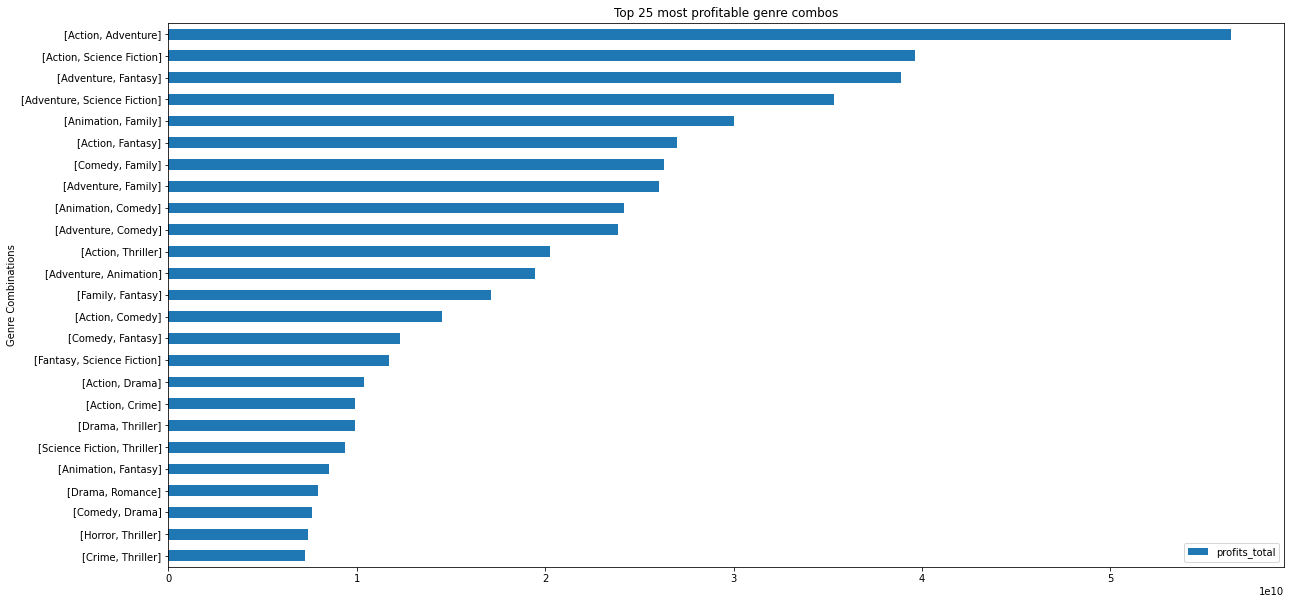

In [80]:
# plot the combinations of genres horizontal bar plot 
combination_df.iloc[:25].plot(kind='barh', 
                  figsize=(20,10), 
                  x='genres_combo', 
                  title='Top 25 most profitable genre combos', 
                  ylabel='Profits',
                 xlabel='Genre Combinations',
                ).invert_yaxis()

* These are the most profitable combinations of genres 

# (1c) What genres give the best ROI? 

In [81]:
len(df) # 4051 

4051

In [85]:
# select rows with just action movies 
# df[df.genre_ids.apply(lambda x: genre in x))]
def calculate_roi(df, genre): 
    sub_df = df[df.genre_ids.apply(lambda x: genre in x)]
    roi_mean = sub_df['roi'].mean() 
    return roi_mean

# get the average ROI for each genre 
roi_genre = tmdb_genres
roi_genre['roi'] = roi_genre.id.apply(lambda x: calculate_roi(df, x))
roi_genre = roi_genre.sort_values(by='roi',ascending=False)
roi_genre

# horror, animation, romance  

,id,genre,roi
10,27,Horror,3.236834
2,16,Animation,3.018519
13,10749,Romance,2.907069
1,12,Adventure,2.722599
12,9648,Mystery,2.661092
8,14,Fantasy,2.638889
16,53,Thriller,2.555403
3,35,Comedy,2.377454
7,10751,Family,2.353353
9,36,History,2.334524


# What genre combinations give the best ROI? 

In [83]:
len(combinations) #171 

171

In [89]:
combination_df['roi_mean'] = 0
combination_df

sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in [28,12]))]

def calculate_roi_combos(df,combo):
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combo))]
    roi_mean = sub_df['roi'].mean()
    return roi_mean 

combination_df['roi_mean'] = combination_df['combinations'].apply(lambda x: calculate_roi_combos(df,x))
combination_df = combination_df.sort_values(by='roi_mean',ascending=False)
combination_df.head(10)


,combinations,profits_total,genres_combo,roi_mean
71,"[80, 27]",503726459,"[Crime, Horror]",5.903846
46,"[16, 878]",845496953,"[Animation, Science Fiction]",5.657692
158,"[10749, 53]",1067969390,"[Romance, Thriller]",5.617143
40,"[16, 14]",8540809766,"[Animation, Fantasy]",5.527869
140,"[27, 53]",7393354020,"[Horror, Thriller]",5.070323
1,"[28, 16]",5292679099,"[Action, Animation]",4.947619
121,"[14, 878]",11729358978,"[Fantasy, Science Fiction]",4.625000
19,"[12, 35]",23884832659,"[Adventure, Comedy]",4.555705
136,"[27, 9648]",2290135411,"[Horror, Mystery]",4.525556
81,"[99, 10751]",119562939,"[Documentary, Family]",4.483333


* So crime and horror and animation,science fiction are in the first twow spots 

# (1d) What genres are the most popular these days? 
* This could be important for a brand like MSFT, for evangelizing and cross selling 
* Movies in the last 10 years 

In [94]:
len(recent_movies)

3956

In [95]:
len(df)

4051

In [96]:
recent_movies.popularity.mean() # 7.877

7.877744944388271

In [97]:
recent_movies = recent_movies.sort_values(by='popularity',ascending=False)
recent_movies.head(10)


,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,revenue,budget,profits,roi
23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,2046239637,300000000,1746239637,6.8
11019,"[28, 53]",245891,en,John Wick,78.123,2014-10-24,John Wick,7.2,10081,88761661,20000000,68761661,4.4
23812,"[28, 12, 16, 878, 35]",324857,en,Spider-Man: Into the Spider-Verse,60.534,2018-12-14,Spider-Man: Into the Spider-Verse,8.4,4048,375540831,90000000,285540831,4.2
11020,"[28, 12, 14]",122917,en,The Hobbit: The Battle of the Five Armies,53.783,2014-12-17,The Hobbit: The Battle of the Five Armies,7.3,8392,956019788,250000000,706019788,3.8
5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,1519557910,220000000,1299557910,6.9
11021,"[28, 878, 12]",118340,en,Guardians of the Galaxy,49.606,2014-08-01,Guardians of the Galaxy,7.9,17958,772776600,170000000,602776600,4.5
20617,"[878, 28, 53]",335984,en,Blade Runner 2049,48.571,2017-10-06,Blade Runner 2049,7.4,6679,259239658,150000000,109239658,1.7
23814,[12],338952,en,Fantastic Beasts: The Crimes of Grindelwald,48.508,2018-11-16,Fantastic Beasts: The Crimes of Grindelwald,6.9,4870,653355901,200000000,453355901,3.3
23815,"[10751, 16, 35, 14, 12]",404368,en,Ralph Breaks the Internet,48.057,2018-11-21,Ralph Breaks the Internet,7.2,2626,529221154,175000000,354221154,3.0
20618,"[28, 12, 878, 18]",315635,en,Spider-Man: Homecoming,46.775,2017-07-07,Spider-Man: Homecoming,7.4,11585,880166924,175000000,705166924,5.0


In [98]:
# select only movies with action in them 
sub_df = recent_movies[recent_movies.genre_ids.apply(lambda x: all(item in x for item in [28]))]
print(len(sub_df)) # 933 rows 
# another way to do the same thing 
sub_df = recent_movies[recent_movies.genre_ids.apply(lambda x: 28 in x)]
print(len(sub_df))

937
937


In [99]:
def calculate_popularity(df,genre):
    sub_df = df[df.genre_ids.apply(lambda x: genre in x)]
    popularity_sum = sub_df['popularity'].sum()
    popularity_mean = popularity_sum/len(sub_df)
    return popularity_mean 

# tmdb_genres = pd.read_csv('zippedData/tmdb/tmdb_genres.csv', index_col=0) #TMDB scraping jupyter notebook
genre_df['popularity_mean'] = genre_df.id.apply(lambda x:calculate_popularity(recent_movies,x))
genre_df = genre_df.sort_values(by='popularity_mean',ascending=False)
genre_df # adventure 13.7   

,id,genre,popularity_mean
1,12,Adventure,13.683767
8,14,Fantasy,12.493379
0,28,Action,11.254951
14,878,Science Fiction,11.100945
2,16,Animation,10.788593
7,10751,Family,10.101350
4,80,Crime,9.689526
12,9648,Mystery,9.109379
17,10752,War,8.791186
16,53,Thriller,8.732615


# (1f) What combinations of genres are most popular these days? 
* make sure more than a few movies 

In [100]:
def calculate_popularity_combos(df, combo):
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combo))]
    popularity_mean = sub_df['popularity'].mean()
    return popularity_mean 

combination_df['popularity_mean'] = combination_df.combinations.apply(lambda x: calculate_popularity_combos(recent_movies,x))
combination_df = combination_df.sort_values(by='popularity_mean',ascending=False)
combination_df.head(10)

,combinations,profits_total,genres_combo,roi_mean,popularity_mean
124,"[14, 10752]",1043751343,"[Fantasy, War]",3.100000,22.494000
107,"[10751, 27]",57503612,"[Family, Horror]",2.600000,20.238000
141,"[27, 10752]",150765124,"[Horror, War]",1.400000,18.297000
30,"[12, 878]",35333277923,"[Adventure, Science Fiction]",3.366667,17.745877
155,"[9648, 37]",98760117,"[Mystery, Western]",1.750000,17.529500
24,"[12, 14]",38876832059,"[Adventure, Fantasy]",3.564706,16.898913
7,"[28, 14]",27001800080,"[Action, Fantasy]",3.240650,16.256075
134,"[36, 37]",-25180886,"[History, Western]",0.500000,15.937000
0,"[28, 12]",56425324863,"[Action, Adventure]",2.624910,15.873925
121,"[14, 878]",11729358978,"[Fantasy, Science Fiction]",4.625000,14.467457


# (1g) Are there any changes in popularity for genres over time?
* line graph on this 

In [101]:
# add a year column to the df 
df['release_year'] = df.release_date.apply(lambda x: int(x.year))
df.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,revenue,budget,profits,roi,release_year
6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,2787965087,237000000,2550965087,11.8,2009
14172,"[28, 12, 878, 14]",140607,en,Star Wars: The Force Awakens,32.281,2015-12-18,Star Wars: The Force Awakens,7.4,12641,2068223624,245000000,1823223624,8.4,2015
23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,2046239637,300000000,1746239637,6.8,2018
14193,"[28, 12, 878, 53]",135397,en,Jurassic World,20.709,2015-06-12,Jurassic World,6.6,14056,1671713208,150000000,1521713208,11.1,2015
14196,"[28, 80, 53]",168259,en,Furious 7,20.396,2015-04-03,Furious 7,7.3,6538,1515047671,190000000,1325047671,8.0,2015


In [184]:
# consider movies made in the last 30 years to obtain an idea of trends 
df = df[df.release_year >= 1990]
print(len(df)) # 4015

# only select action movies 
action_movies = df[df.genre_ids.apply(lambda x: 28 in x)]
# group by popularity 
action_movies = action_movies.groupby('release_year').popularity.mean().reset_index()
action_movies

# get popularity for a single genre as

def popularity_by_genre(df, genre):
    sub_df = df[df.genre_ids.apply(lambda x: genre in x)]
    grouped_df = sub_df.groupby('release_year').popularity.mean().reset_index() 
    return grouped_df


4015


19


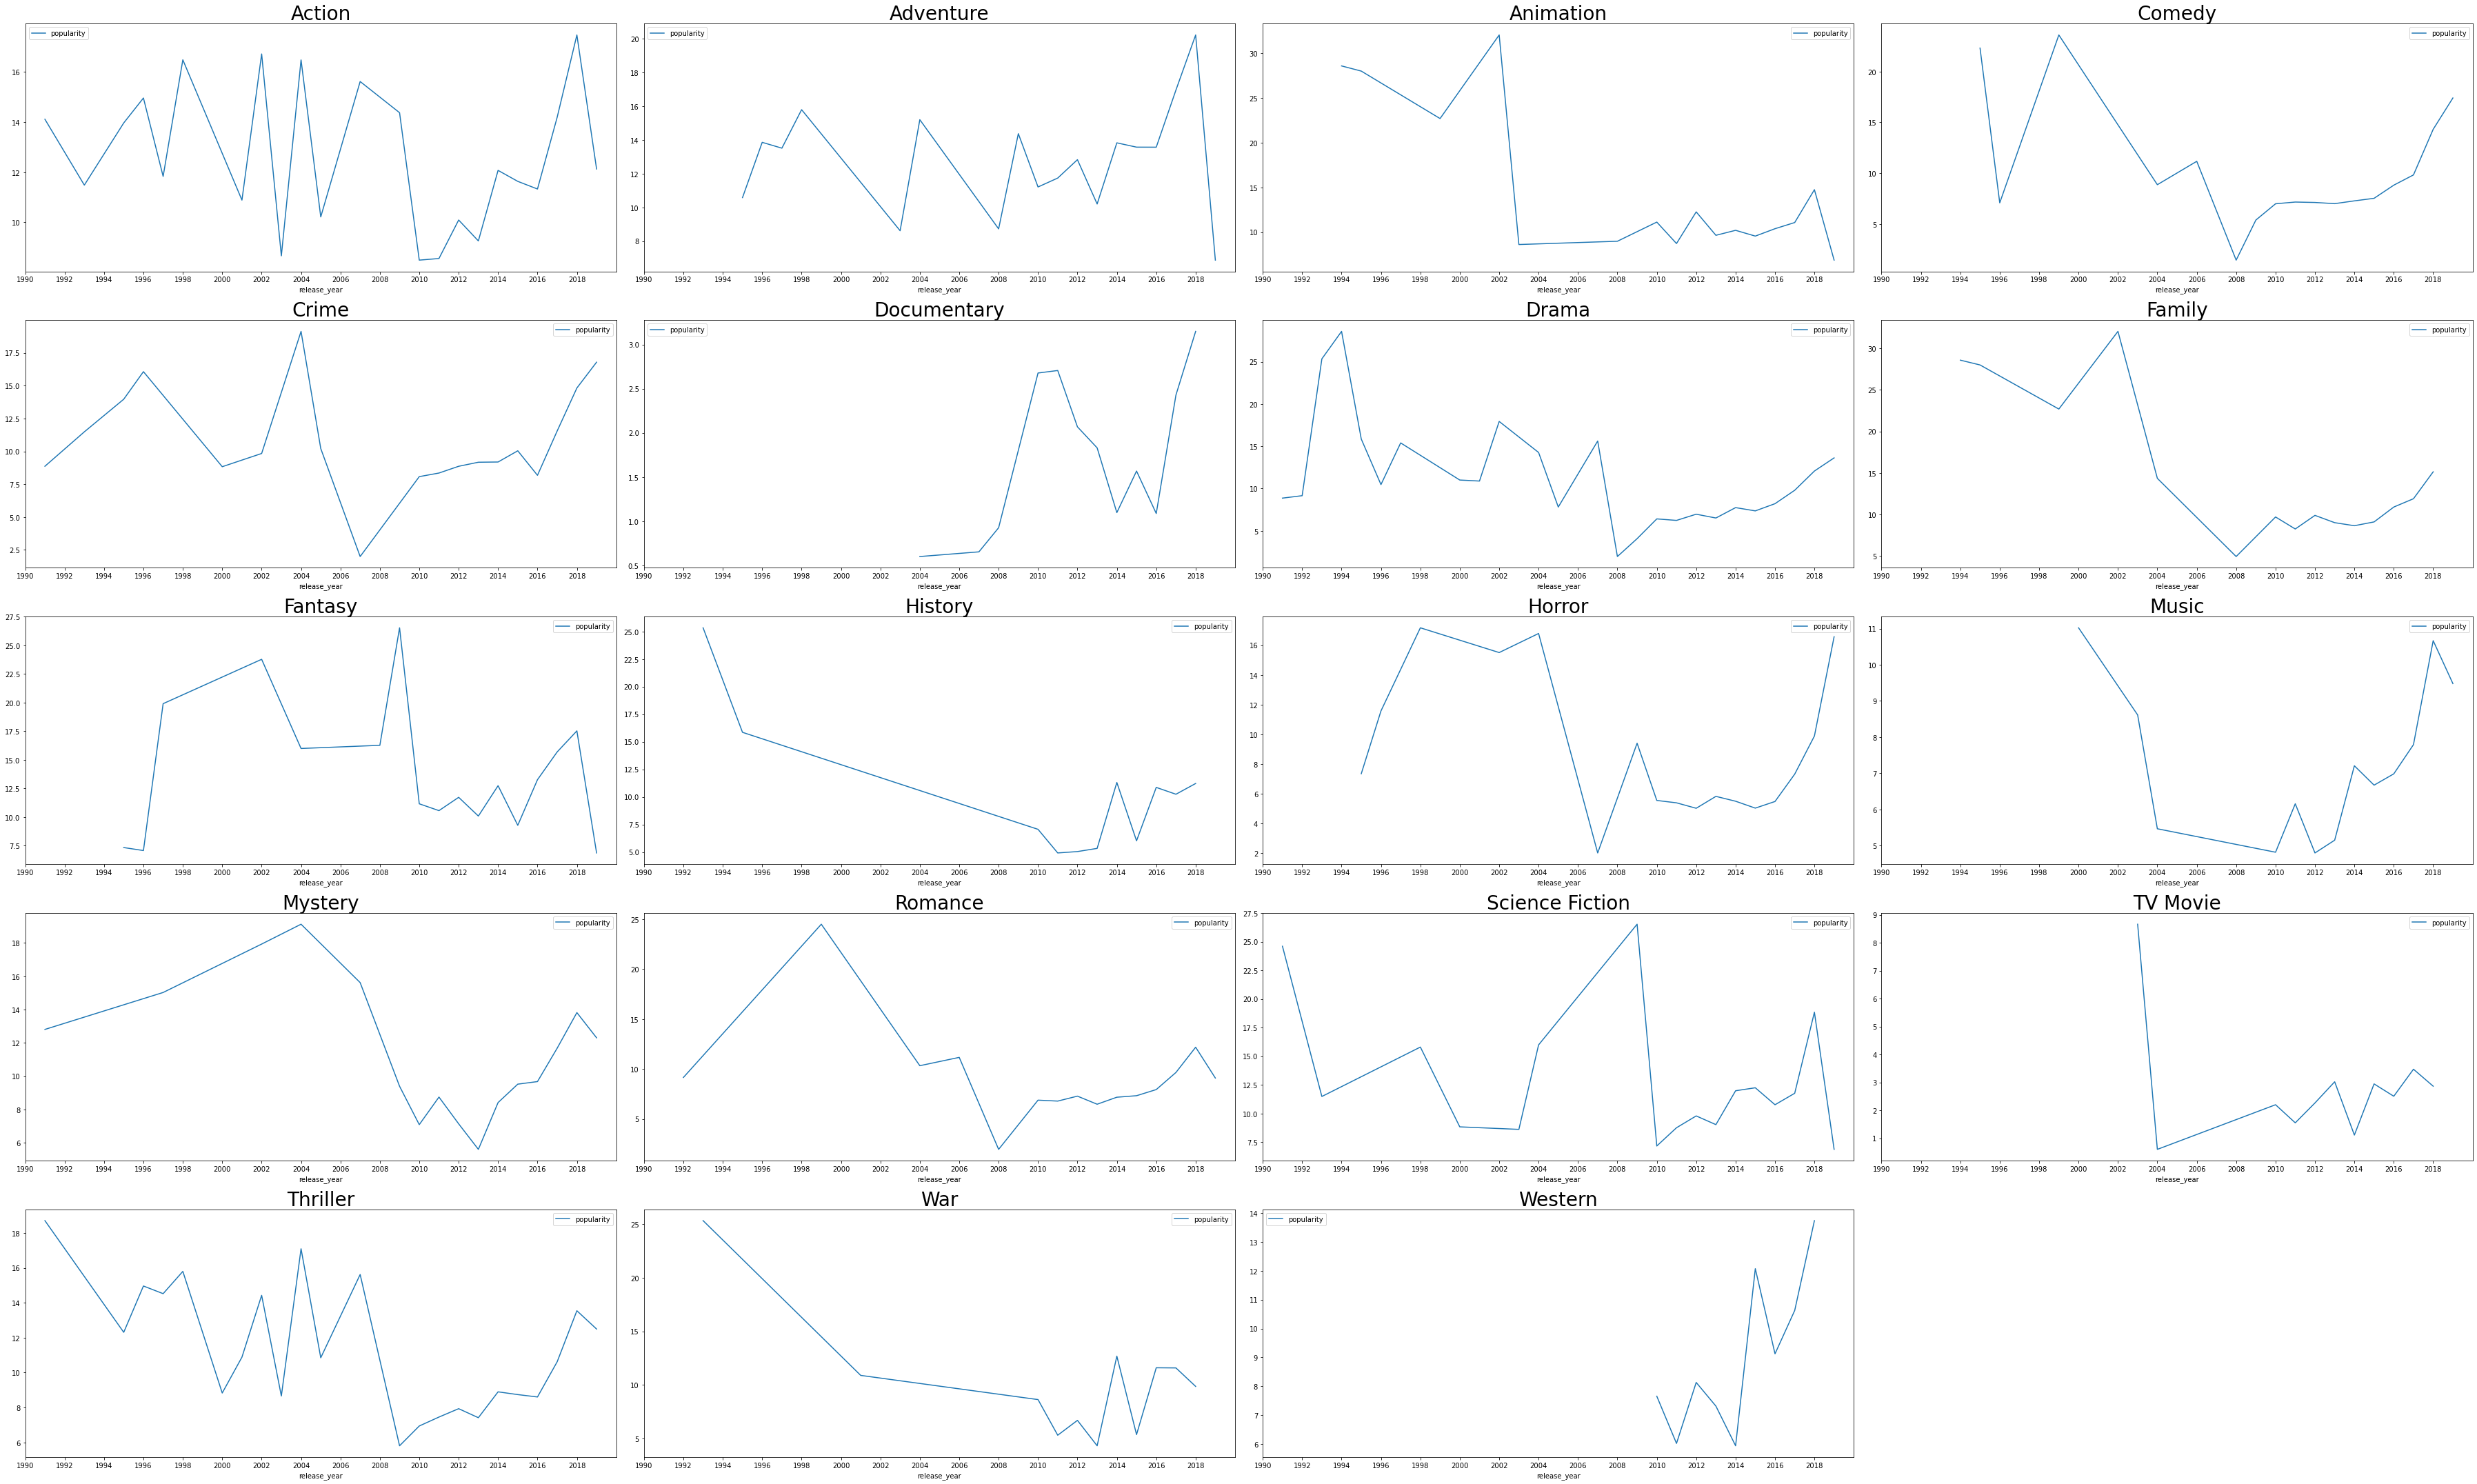

In [187]:
print(len(tmdb_genres))
fig, axs = plt.subplots(nrows=5,ncols=4,figsize=(50,30))
axs_list = [item for sublist in axs for item in sublist]

for index, genre in enumerate(tmdb_genres['id']):
    grouped_df = popularity_by_genre(df, genre)
    ax = axs_list.pop(0)
    grouped_df.plot(x='release_year',y='popularity',ax=ax)
    ax.set_title(tmdb_genres['genre'][tmdb_genres.id==genre].iloc[0], fontsize=28)
    ax.set_xlim(1990,2020)
    ax.set_xticks(range(1990,2020,2))

for ax in axs_list:
    ax.remove()

plt.tight_layout()


* of note: Horror, dramas comedies, and westerns seem to be on the rise 